In [4]:
import pandas as pd
from datetime import datetime, timedelta

# Load the main dataset
main_file_path = 'TUNEL.csv'
data = pd.read_csv(main_file_path)

# Load the holiday dates file
holiday_file_path = 'holiday_dates_2022.csv'
holiday_dates = pd.read_csv(holiday_file_path)

# Load the weather data file
weather_file_path = 'istanbul_hourly_weather_2022.csv'
weather_data = pd.read_csv(weather_file_path)

# Ensure date formats are consistent
holiday_dates['Date'] = pd.to_datetime(holiday_dates['Date'])
data['transition_date'] = pd.to_datetime(data['transition_date'])
weather_data['time'] = pd.to_datetime(weather_data['time'])

# Remove the 'line' column
if 'line' in data.columns:
    data.drop(columns=['line'], inplace=True)

# Generate a complete time range for the year (8761 rows)
start_date = datetime(2022, 1, 1, 0)
end_date = datetime(2022, 12, 31, 23)
full_time_range = pd.date_range(start=start_date, end=end_date + timedelta(hours=1), freq='H')

# Create a full DataFrame for merging
full_data = pd.DataFrame({
    'transition_date': full_time_range.date,
    'transition_hour': full_time_range.strftime('%H:%M:%S'),
    'week_day': (full_time_range.dayofweek + 2) % 7 + 1  # Saturday as 1, Sunday as 2, ...
})

# Ensure the 'transition_date' column is datetime in both datasets
full_data['transition_date'] = pd.to_datetime(full_data['transition_date'])

# Merge the full dataset with the existing data
merged_data = pd.merge(full_data, data, on=['transition_date', 'transition_hour'], how='left')

# Fill missing values for passengers with 0
merged_data['number_of_passenger'] = merged_data['number_of_passenger'].fillna(0)

# Add a 'holiday' column, marking 1 for holiday dates and 0 otherwise
merged_data['holiday'] = merged_data['transition_date'].isin(holiday_dates['Date']).astype(int)

# Merge the temperature data from the weather dataset
weather_data = weather_data[['time', 'temp']].rename(columns={'time': 'timestamp'})
merged_data['timestamp'] = pd.to_datetime(
    merged_data['transition_date'].astype(str) + ' ' + merged_data['transition_hour']
)
merged_data = pd.merge(merged_data, weather_data, left_on='timestamp', right_on='timestamp', how='left')

# Drop the timestamp column to keep the dataset clean
merged_data.drop(columns=['timestamp'], inplace=True)

# Save the resulting dataset to a new file
merged_data.sort_values(by=['transition_date', 'transition_hour'], inplace=True)
output_file_path = 'TUNEL_corrected_with_holidays_and_temp.csv'
merged_data.to_csv(output_file_path, index=False)

print(f"Processed file saved to {output_file_path}")

Processed file saved to TUNEL_corrected_with_holidays_and_temp.csv


In [5]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np

# Load the processed dataset with holidays and temperature
file_path = 'TUNEL_corrected_with_holidays_and_temp.csv'
data = pd.read_csv(file_path)

# Ensure the transition_date and transition_hour form a proper timestamp
data['timestamp'] = pd.to_datetime(data['transition_date'] + ' ' + data['transition_hour'])

# Sort data by timestamp
data = data.sort_values(by='timestamp')

# Perform STL decomposition on the 'number_of_passenger' column
stl = STL(data['number_of_passenger'], period=24, robust=True)  # period=24 for hourly data with daily seasonality
result = stl.fit()

# Extract components
data['trend'] = result.trend
data['seasonal'] = result.seasonal
data['residual'] = result.resid

# Identify outliers in the residual component
threshold = 3 * np.std(data['residual'])
data['outlier'] = (abs(data['residual']) > threshold).astype(int)

# Handle outliers by replacing them with the trend + seasonal components
data['number_of_passenger_corrected'] = data['number_of_passenger']
data.loc[data['outlier'] == 1, 'number_of_passenger_corrected'] = (
    data['trend'] + data['seasonal']
)

# Drop the extra timestamp column for cleanliness
data.drop(columns=['timestamp'], inplace=True)

# Save the corrected data to a new file
output_file_path = 'TUNEL_corrected_with_outliers_handled.csv'
data.to_csv(output_file_path, index=False)

print(f"Outlier-handled dataset saved to {output_file_path}")


Outlier-handled dataset saved to TUNEL_corrected_with_outliers_handled.csv


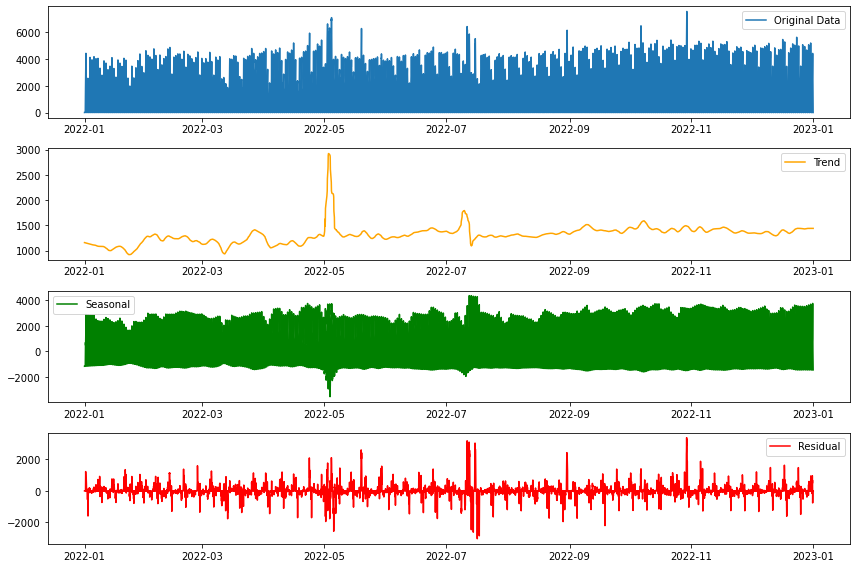

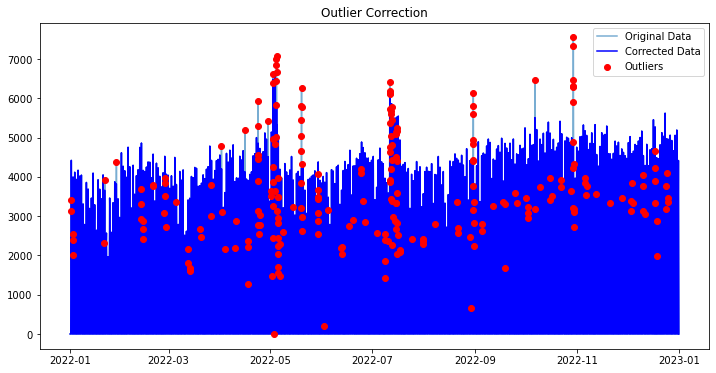

Outlier-handled dataset saved to TUNEL_corrected_with_outliers_handled.csv


In [6]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt

# Load the processed dataset with holidays and temperature
file_path = 'TUNEL_corrected_with_holidays_and_temp.csv'
data = pd.read_csv(file_path)

# Ensure the transition_date and transition_hour form a proper timestamp
data['timestamp'] = pd.to_datetime(data['transition_date'] + ' ' + data['transition_hour'])

# Sort data by timestamp
data = data.sort_values(by='timestamp')

# Perform STL decomposition on the 'number_of_passenger' column
stl = STL(data['number_of_passenger'], period=24, robust=True)  # period=24 for hourly data with daily seasonality
result = stl.fit()

# Extract components
data['trend'] = result.trend
data['seasonal'] = result.seasonal
data['residual'] = result.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(data['timestamp'], data['number_of_passenger'], label='Original Data')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(data['timestamp'], data['trend'], label='Trend', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(data['timestamp'], data['seasonal'], label='Seasonal', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(data['timestamp'], data['residual'], label='Residual', color='red')
plt.legend()
plt.tight_layout()
plt.show()

# Identify outliers in the residual component
threshold = 3 * np.std(data['residual'])
data['outlier'] = (abs(data['residual']) > threshold).astype(int)

# Handle outliers by replacing them with the trend + seasonal components
data['number_of_passenger_corrected'] = data['number_of_passenger']
data.loc[data['outlier'] == 1, 'number_of_passenger_corrected'] = (
    data['trend'] + data['seasonal']
)

# Plot to show outlier correction
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['number_of_passenger'], label='Original Data', alpha=0.6)
plt.plot(data['timestamp'], data['number_of_passenger_corrected'], label='Corrected Data', color='blue')
plt.scatter(data['timestamp'][data['outlier'] == 1],
            data['number_of_passenger'][data['outlier'] == 1],
            color='red', label='Outliers', zorder=5)
plt.title('Outlier Correction')
plt.legend()
plt.show()

# Drop the extra timestamp column for cleanliness
data.drop(columns=['timestamp'], inplace=True)

# Save the corrected data to a new file
output_file_path = 'TUNEL_corrected_with_outliers_handled.csv'
data.to_csv(output_file_path, index=False)

print(f"Outlier-handled dataset saved to {output_file_path}")


Validation Metrics:
R2 Score: 0.9920
RMSE: 135.3238
MAE: 70.6807

Test Metrics:
R2 Score: 0.9887
RMSE: 160.1390
MAE: 80.4319


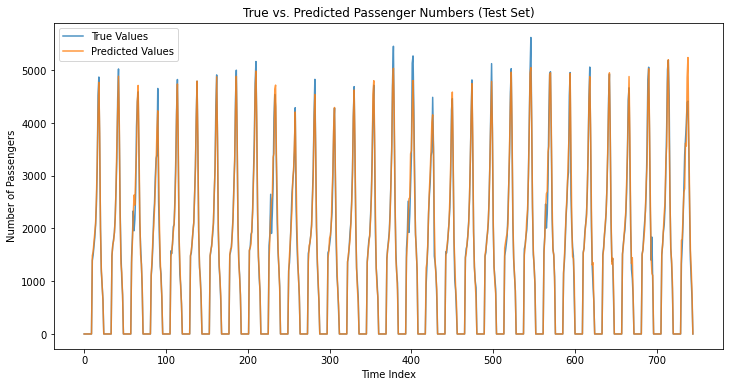

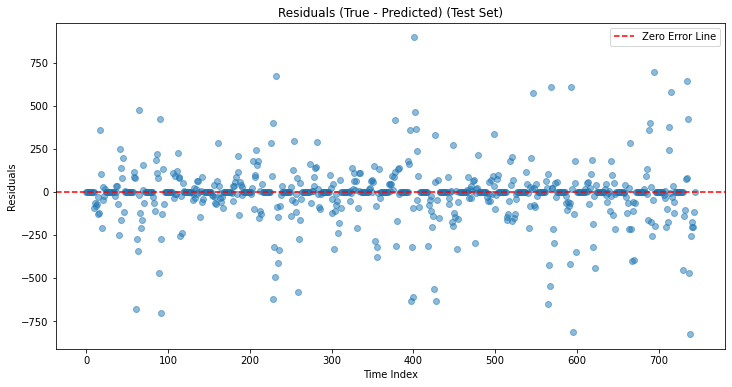

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the final dataset
file_path = 'TUNEL_corrected_with_outliers_handled.csv'
data = pd.read_csv(file_path)

# Ensure transition_date and transition_hour are combined for time
data['timestamp'] = pd.to_datetime(data['transition_date'] + ' ' + data['transition_hour'])
data = data.sort_values(by='timestamp')

# Handle missing values in 'temp'
data['temp'] = data['temp'].fillna(data['temp'].mean())

# Add lagged features
data['lag_1'] = data['number_of_passenger_corrected'].shift(1)
data['lag_24'] = data['number_of_passenger_corrected'].shift(24)  # Previous day (same hour)

# Add rolling mean and rolling standard deviation
data['rolling_mean_24'] = data['number_of_passenger_corrected'].rolling(window=24).mean()
data['rolling_std_24'] = data['number_of_passenger_corrected'].rolling(window=24).std()

# Drop rows with NaN values after adding lagged and rolling features
data = data.dropna()

# Define features and target
features = [
    'trend', 'seasonal', 'temp', 'holiday', 'week_day',
    'lag_1', 'lag_24', 'rolling_mean_24', 'rolling_std_24'
]
target = 'number_of_passenger_corrected'

X = data[features]
y = data[target]

# Split the data
train_data = data[data['timestamp'] < '2022-11-01']
val_data = data[(data['timestamp'] >= '2022-11-01') & (data['timestamp'] < '2022-12-01')]
test_data = data[data['timestamp'] >= '2022-12-01']

X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on validation and test sets
y_val_pred = rf_regressor.predict(X_val)
y_test_pred = rf_regressor.predict(X_test)

# Evaluate the model on validation data
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)

print("Validation Metrics:")
print(f"R2 Score: {val_r2:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")

# Evaluate the model on test data
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"R2 Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")

# Plot True vs. Predicted values for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', alpha=0.8)
plt.plot(y_test_pred, label='Predicted Values', alpha=0.8)
plt.title('True vs. Predicted Passenger Numbers (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Plot Residuals for test set
residuals = y_test - y_test_pred
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.title('Residuals (True - Predicted) (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Validation Metrics:
R2 Score: 0.9860
RMSE: 178.6162
MAE: 101.9593

Test Metrics:
R2 Score: 0.9856
RMSE: 180.7884
MAE: 103.3223


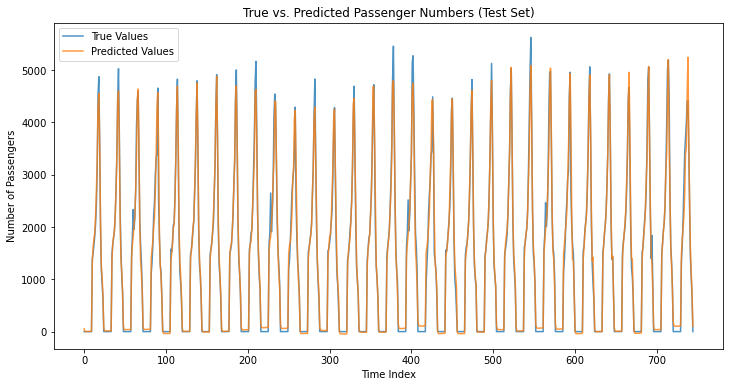

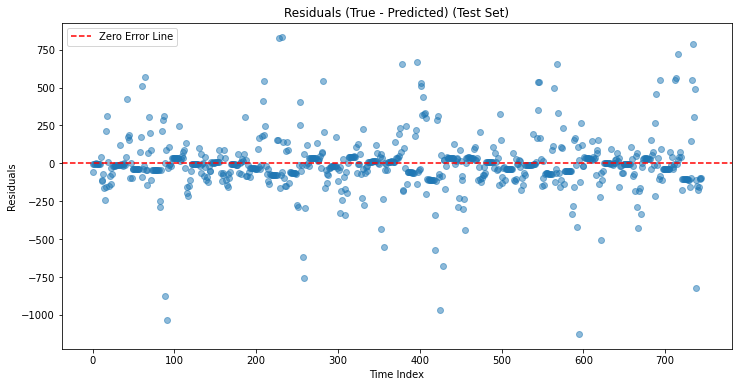

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the final dataset
file_path = 'TUNEL_corrected_with_outliers_handled.csv'
data = pd.read_csv(file_path)

# Ensure transition_date and transition_hour are combined for time
data['timestamp'] = pd.to_datetime(data['transition_date'] + ' ' + data['transition_hour'])
data = data.sort_values(by='timestamp')

# Handle missing values in 'temp'
data['temp'] = data['temp'].fillna(data['temp'].mean())

# Add lagged features
data['lag_1'] = data['number_of_passenger_corrected'].shift(1)
data['lag_24'] = data['number_of_passenger_corrected'].shift(24)  # Previous day (same hour)

# Add rolling mean and rolling standard deviation
data['rolling_mean_24'] = data['number_of_passenger_corrected'].rolling(window=24).mean()
data['rolling_std_24'] = data['number_of_passenger_corrected'].rolling(window=24).std()

# Drop rows with NaN values after adding lagged and rolling features
data = data.dropna()

# Define features and target
features = [
    'trend', 'seasonal', 'temp', 'holiday', 'week_day',
    'lag_1', 'lag_24', 'rolling_mean_24', 'rolling_std_24'
]
target = 'number_of_passenger_corrected'

X = data[features]
y = data[target]

# Split the data
train_data = data[data['timestamp'] < '2022-11-01']
val_data = data[(data['timestamp'] >= '2022-11-01') & (data['timestamp'] < '2022-12-01')]
test_data = data[data['timestamp'] >= '2022-12-01']

X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

# Initialize and train the Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predict on validation and test sets
y_val_pred = linear_regressor.predict(X_val)
y_test_pred = linear_regressor.predict(X_test)

# Evaluate the model on validation data
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)

print("Validation Metrics:")
print(f"R2 Score: {val_r2:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")

# Evaluate the model on test data
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"R2 Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")

# Plot True vs. Predicted values for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', alpha=0.8)
plt.plot(y_test_pred, label='Predicted Values', alpha=0.8)
plt.title('True vs. Predicted Passenger Numbers (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Plot Residuals for test set
residuals = y_test - y_test_pred
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.title('Residuals (True - Predicted) (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [15]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load the dataset
file_path = 'TUNEL_corrected_with_outliers_handled.csv'
data = pd.read_csv(file_path)

# Combine transition_date and transition_hour into a timestamp
data['timestamp'] = pd.to_datetime(data['transition_date'] + ' ' + data['transition_hour'])
data = data.sort_values(by='timestamp')

# Extract the time series for passenger numbers
ts_data = data[['timestamp', 'number_of_passenger_corrected']].set_index('timestamp')

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(ts_data['number_of_passenger_corrected'])

# Display test results
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_test[0]:.4f}")
print(f"p-value: {adf_test[1]:.4f}")
print(f"Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value:.4f}")

# Interpret the p-value
if adf_test[1] < 0.05:
    print("\nThe series is stationary (p-value < 0.05).")
else:
    print("\nThe series is not stationary (p-value >= 0.05).")


Augmented Dickey-Fuller Test Results:
ADF Statistic: -7.2929
p-value: 0.0000
Critical Values:
   1%: -3.4311
   5%: -2.8619
   10%: -2.5669

The series is stationary (p-value < 0.05).


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:     number_of_passenger_corrected   No. Observations:                 7272
Model:                          SARIMAX(5, 0, 2)   Log Likelihood              -50190.045
Date:                           Thu, 14 Nov 2024   AIC                         100412.089
Time:                                   19:03:16   BIC                         100522.358
Sample:                               01-02-2022   HQIC                        100450.014
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
temp                2.1493      1.118      1.923      0.055      -0.042       4.340
holiday            85.8199  

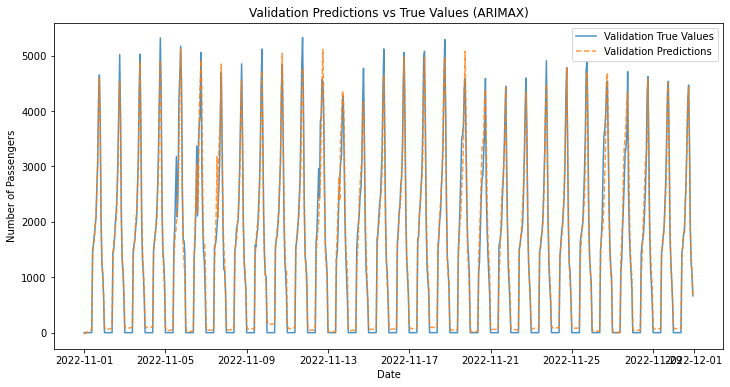

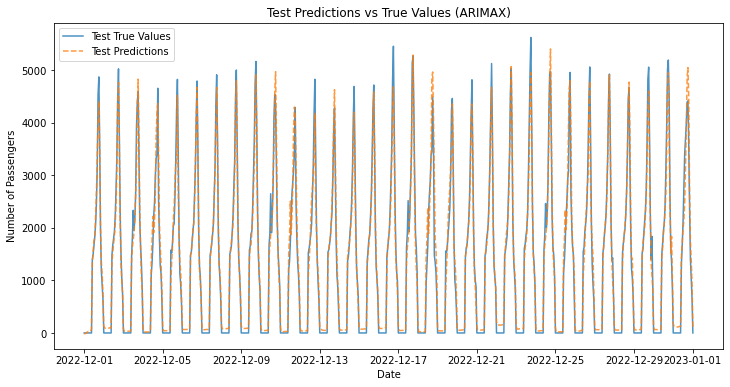

In [18]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'TUNEL_corrected_with_outliers_handled.csv'
data = pd.read_csv(file_path)

# Combine transition_date and transition_hour into a timestamp
data['timestamp'] = pd.to_datetime(data['transition_date'] + ' ' + data['transition_hour'])
data = data.sort_values(by='timestamp')

# Set timestamp as the index
data.set_index('timestamp', inplace=True)

# Feature Engineering
data['hour_of_day'] = data.index.hour
data['lag_1'] = data['number_of_passenger_corrected'].shift(1)
data['lag_24'] = data['number_of_passenger_corrected'].shift(24)
data['rolling_mean_24'] = data['number_of_passenger_corrected'].rolling(window=24).mean()
data['rolling_std_24'] = data['number_of_passenger_corrected'].rolling(window=24).std()
data['temp'] = data['temp'].fillna(data['temp'].mean())  # Handle missing values
data.dropna(inplace=True)  # Drop rows with NaN values after adding lagged and rolling features

# Use the corrected passenger numbers as the target variable
ts_data = data['number_of_passenger_corrected']

# Define external regressors (exogenous variables)
exog_features = data[['temp', 'holiday', 'week_day', 'hour_of_day', 'lag_1', 'lag_24', 'rolling_mean_24', 'rolling_std_24']]

# Split the data
train_data = ts_data[:'2022-10-31']
val_data = ts_data['2022-11-01':'2022-11-30']
test_data = ts_data['2022-12-01':]

train_exog = exog_features[:'2022-10-31']
val_exog = exog_features['2022-11-01':'2022-11-30']
test_exog = exog_features['2022-12-01':]

# Train ARIMAX model with exogenous features
model = SARIMAX(train_data, exog=train_exog, order=(5, 0, 2))  # Example order, tune using pmdarima
result = model.fit()
print(result.summary())

# Forecast with exogenous variables
val_forecast = result.get_forecast(steps=len(val_data), exog=val_exog).predicted_mean
test_forecast = result.get_forecast(steps=len(test_data), exog=test_exog).predicted_mean

# Evaluate the model on validation data
val_rmse = np.sqrt(mean_squared_error(val_data, val_forecast))
val_mae = mean_absolute_error(val_data, val_forecast)
val_r2 = r2_score(val_data, val_forecast)

print("\nValidation Metrics:")
print(f"R2 Score: {val_r2:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")

# Evaluate the model on test data
test_rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
test_mae = mean_absolute_error(test_data, test_forecast)
test_r2 = r2_score(test_data, test_forecast)

print("\nTest Metrics:")
print(f"R2 Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")

# Plot True vs. Predicted values for validation set
plt.figure(figsize=(12, 6))
plt.plot(val_data.index, val_data, label='Validation True Values', alpha=0.8)
plt.plot(val_data.index, val_forecast, label='Validation Predictions', alpha=0.8, linestyle='--')
plt.title('Validation Predictions vs True Values (ARIMAX)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Plot True vs. Predicted values for test set
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Test True Values', alpha=0.8)
plt.plot(test_data.index, test_forecast, label='Test Predictions', alpha=0.8, linestyle='--')
plt.title('Test Predictions vs True Values (ARIMAX)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()